In [1]:
# Python modules.
import datetime as dt
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../data")


# Other modules.
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)
import numpy as np
import pandas as pd

# Library.
from src.utils import (
    make_a_sound,
    prepare_submission,
    submit_file,
    get_submission_scores,
)
from src.eda import (
    distplot,
    correlation_heatmap,
    compare_predictions_and_real_values,
    vizualize_feature_importance,
    vizualise_residual,
)
from src.preprocessing import (
    apply_log_to_output,
    reverse_log,
    fill_df_navalues,
    scale_and_encoder_features,
    encode_categories_using_encoders_and_scalers,
    split_X_y_in_train_test_sets,
    create_polynomial_features,
    generate_polynomial_column_using_polynomial_feature_encoder,
    get_dummies,
)

In [2]:
# Loading data
df_train = (
    pd.concat([
    pd.read_csv("data/train.csv"),
    pd.read_csv("data/training_extra.csv"),
    ])
)

print(df_train.shape)
df_test = pd.read_csv("data/test.csv")

(3994318, 11)


In [3]:
df_train

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
3694313,4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
3694314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
3694315,4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470
3694316,4194316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339,22.32269


### EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 365.7+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 193773 non-null  object 
 2   Material              194387 non-null  object 
 3   Size                  195619 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    195038 non-null  object 
 6   Waterproof            195189 non-null  object 
 7   Style                 194847 non-null  object 
 8   Color                 193215 non-null  object 
 9   Weight Capacity (kg)  199923 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


<Figure size 1900x1000 with 0 Axes>

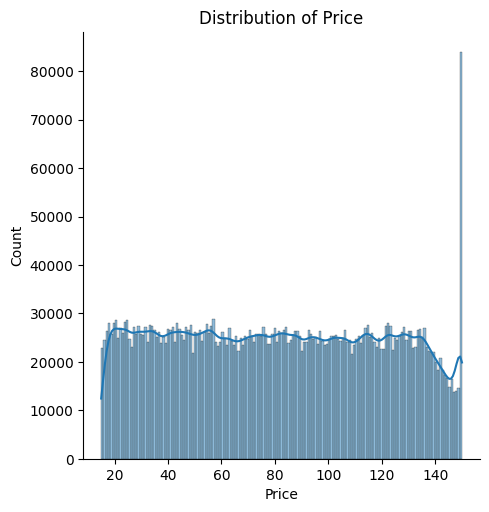

<Figure size 1900x1000 with 0 Axes>

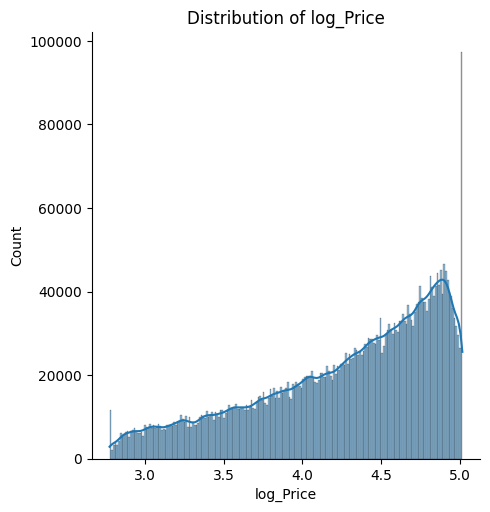

In [6]:
# distplot(df=df_train, variable_name="Price")
# df_train = df_train.drop(df_train[df_train.Price >= 140].index)
distplot(df=df_train, variable_name="Price")
df_train = apply_log_to_output(df=df_train, output_column_name="Price")
distplot(df=df_train, variable_name="log_Price")

## Preprocessing

In [7]:
# Preprocessing
df_train_filled = fill_df_navalues(df=df_train)
df_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
 11  log_Price             float64
dtypes: float64(4), int64(1), object(7)
memory usage: 525.2+ MB


## Creating new features

In [8]:
def find_weight_group(x):
    if x <= 7:
        return "Low Low"
    elif (x > 7) & (x <= 15):
        return "Low"
    elif (x > 15) & (x <= 22):
        return "Low Medium"
    elif (x > 22) & (x <= 30):
        return "Medium"
    elif (x > 30) & (x <= 37):
        return "Medium"
    else:
        return "High"


def find_compartment_group(x):
    if x <= 3:
        return "Low"
    elif (x > 3) & (x <= 5):
        return "Medium"
    elif (x > 5) & (x <= 7):
        return "Medium Plus"
    elif x > 7:
        return "High"


def find_style(x):
    if x in ["Under Armour", "Nike"]:
        return "Street Wear"
    elif x == "Jansport":
        return "Casual"
    elif x in ["Adidas", "Puma"]:
        return "Fancy Street Wear"


def find_material_price(x):
    if x in ["Leather"]:
        return "Expensive"
    elif x in ["Canvas", "Nylon"]:
        return "Medium"
    elif x in ["Polyester"]:
        return "Cheap"


def create_new_features(input_df: pd.DataFrame) -> pd.DataFrame:
    """Create variables using deduction and previous variables.
    Creating categories basically.

    :param input_df:
    :return pd.DataFrame:
    """
    output_df = input_df.copy()
    output_df["Weight Group"] = output_df["Weight Capacity (kg)"].apply(
        lambda x: find_weight_group(x)
    )
    output_df["Compartments"] = output_df.Compartments.astype("category")
    output_df["Compartement Group"] = output_df["Compartments"].apply(
        lambda x: find_compartment_group(x)
    )
    output_df["Brand Style"] = output_df["Brand"].apply(lambda x: find_style(x))
    output_df["Material Category"] = output_df["Material"].apply(lambda x: find_material_price(x))
    # output_df["Weight capacity 2"] = output_df["Weight Capacity (kg)"] ** 2
    return output_df


df_train_filled = create_new_features(input_df=df_train_filled)
df_train_filled.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 16 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Brand                 object  
 2   Material              object  
 3   Size                  object  
 4   Compartments          category
 5   Laptop Compartment    object  
 6   Waterproof            object  
 7   Style                 object  
 8   Color                 object  
 9   Weight Capacity (kg)  float64 
 10  Price                 float64 
 11  log_Price             float64 
 12  Weight Group          object  
 13  Compartement Group    object  
 14  Brand Style           object  
 15  Material Category     object  
dtypes: category(1), float64(3), int64(1), object(11)
memory usage: 620.4+ MB


In [9]:
df_train_filled

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,log_Price,Weight Group,Compartement Group,Brand Style,Material Category
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875,4.728792,Low,Medium Plus,Casual,Expensive
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056,4.246787,Medium,High,Casual,Medium
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320,3.693200,Low Medium,Low,Street Wear,Expensive
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793,4.401926,Low,High,Street Wear,Medium
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312,4.466174,Low Medium,Low,Fancy Street Wear,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694313,4194313,Nike,Canvas,Medium,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460,4.661027,Medium,Low,Street Wear,Medium
3694314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043,4.815354,Low Medium,High,Fancy Street Wear,Expensive
3694315,4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470,5.005185,Low Medium,High,Casual,Medium
3694316,4194316,Puma,Canvas,Medium,2.0,No,No,Backpack,Gray,28.783339,22.32269,3.149427,Medium,Low,Fancy Street Wear,Medium


In [10]:
df_polynomial_transform, pf = create_polynomial_features(df=df_train_filled.loc[:, ["id", "Weight Capacity (kg)"]], polynomial_degree=3)
df_polynomial_transform

,id,Original,polynomial_1,polynomial_2
0,0,11.611723,134.832107,1565.633046
1,1,27.078537,733.247143,19855.259594
2,2,16.643760,277.014745,4610.566922
3,3,12.937220,167.371669,2165.324158
4,4,17.749338,315.039016,5591.734125
...,...,...,...,...
3994313,4194313,28.098120,789.504350,22183.588004
3994314,4194314,17.379531,302.048098,5249.454295
3994315,4194315,17.037708,290.283489,4945.765273
3994316,4194316,28.783339,828.480619,23846.438743


In [11]:
df_train_filled = pd.merge(
    df_train_filled,
    df_polynomial_transform,
    on="id",
    how="left",
).drop(columns=["Original"])
df_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 18 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Brand                 object  
 2   Material              object  
 3   Size                  object  
 4   Compartments          category
 5   Laptop Compartment    object  
 6   Waterproof            object  
 7   Style                 object  
 8   Color                 object  
 9   Weight Capacity (kg)  float64 
 10  Price                 float64 
 11  log_Price             float64 
 12  Weight Group          object  
 13  Compartement Group    object  
 14  Brand Style           object  
 15  Material Category     object  
 16  polynomial_1          float64 
 17  polynomial_2          float64 
dtypes: category(1), float64(5), int64(1), object(11)
memory usage: 521.9+ MB


In [12]:
# Scaling
df_train_filled_n, scalers_and_encoders = scale_and_encoder_features(df=df_train_filled, output_column_name="Price")
df_train_filled_n.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 18 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Brand                 category
 2   Material              category
 3   Size                  category
 4   Compartments          category
 5   Laptop Compartment    category
 6   Waterproof            category
 7   Style                 category
 8   Color                 category
 9   Weight Capacity (kg)  float64 
 10  Price                 float64 
 11  log_Price             float64 
 12  Weight Group          category
 13  Compartement Group    category
 14  Brand Style           category
 15  Material Category     category
 16  polynomial_1          float64 
 17  polynomial_2          float64 
dtypes: category(12), float64(5), int64(1)
memory usage: 228.6 MB


In [13]:
df_train_dummy = get_dummies(df=df_train_filled_n)
df_train_dummy

,id,Weight Capacity (kg),Price,log_Price,polynomial_1,polynomial_2,Brand_0,Brand_1,Brand_2,Brand_3,...,Compartement Group_0,Compartement Group_1,Compartement Group_2,Compartement Group_3,Brand Style_0,Brand Style_1,Brand Style_2,Material Category_0,Material Category_1,Material Category_2
0,0,-0.917719,112.15875,0.796513,-0.944346,-0.901180,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,1.300576,68.88056,-0.035393,1.428501,1.493661,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,-0.196010,39.17320,-0.990845,-0.380560,-0.502477,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3,-0.727612,80.60793,0.232366,-0.815319,-0.822657,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,4,-0.037445,86.02312,0.343253,-0.229786,-0.374003,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994313,4194313,1.446807,104.74460,0.679555,1.651574,1.798532,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3994314,4194314,-0.090483,122.39043,0.945912,-0.281298,-0.418821,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3994315,4194315,-0.139509,148.18470,1.273548,-0.327947,-0.458586,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3994316,4194316,1.545083,22.32269,-1.929360,1.806123,2.016265,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Correlation matrix.

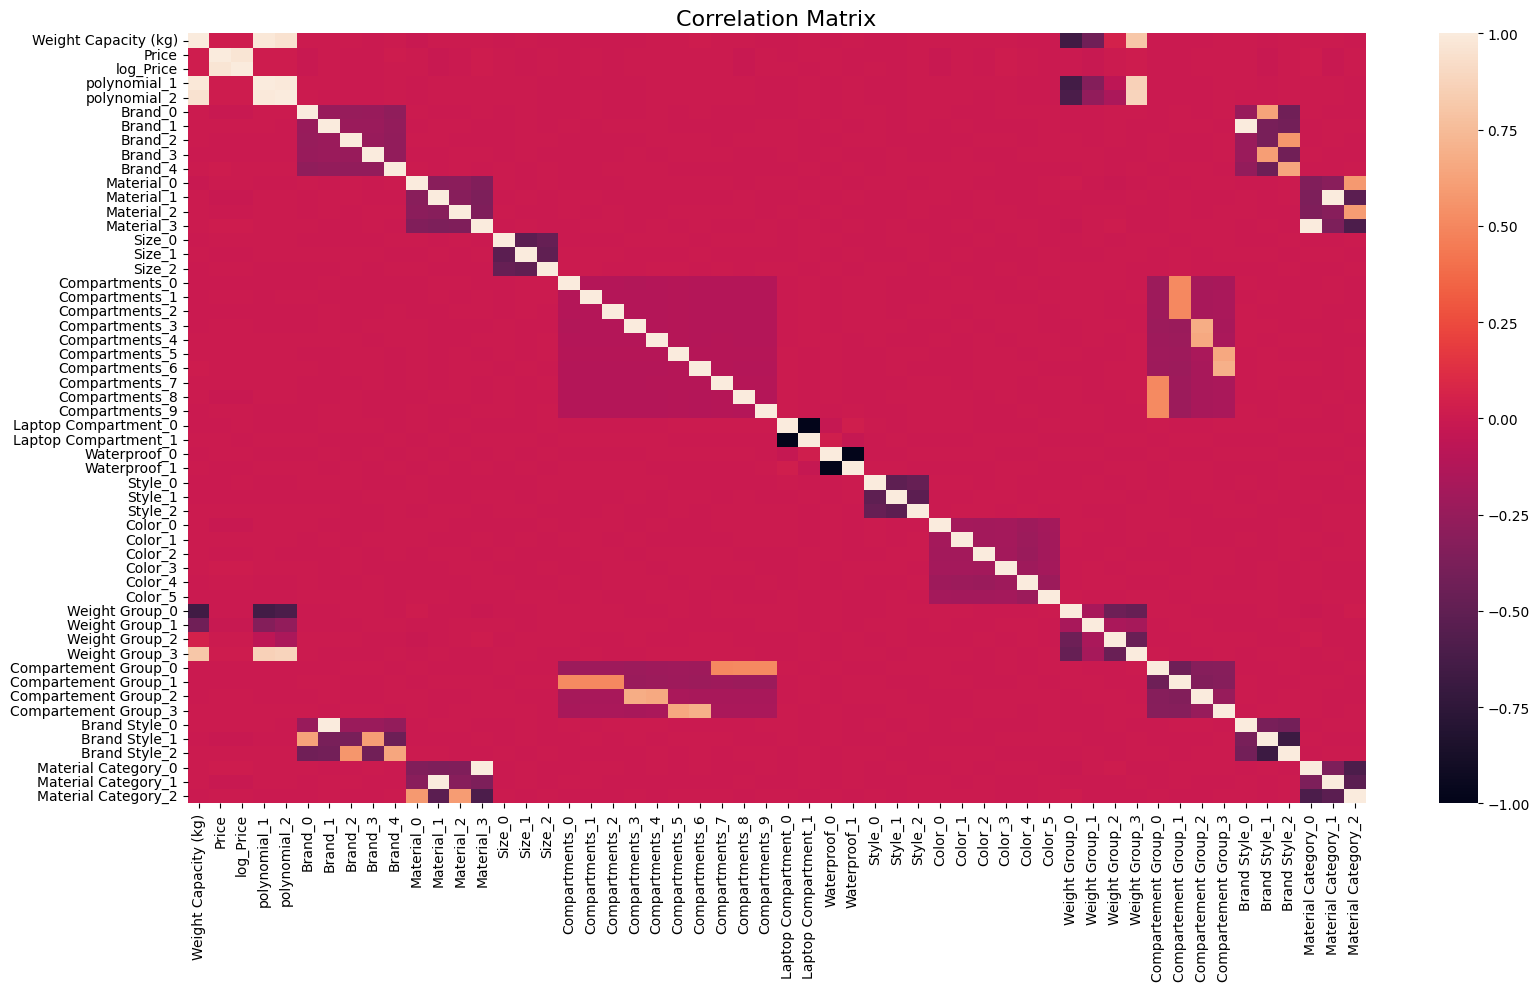

In [14]:
corr = (
    df_train_dummy
    .select_dtypes(include=["float64", "int64"])
    .drop(columns=["id", "index"], errors='ignore')
    .corr()
)
correlation_heatmap(df_correlation=corr)

In [15]:
column_names = df_train_dummy.drop(columns=["Price", "log_Price", "index", "id"], errors="ignore").columns
X = df_train_dummy.loc[:, column_names]
y = df_train_dummy.loc[:, ["Price"]]
X_train, X_test, y_train, y_test = split_X_y_in_train_test_sets(X=X, y=y)
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (3195454, 52)
Test shape: (798864, 52)


In [16]:
from sklearn.metrics import (
    mean_squared_error,
)
from sklearn.linear_model import (
    Ridge,
    LinearRegression,
    Lasso,
)
from sklearn.ensemble import (
    RandomForestRegressor,
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from src.model import (
    get_linear_regression_model,
    get_ridge_model,
    get_lasso_model,
    get_random_forest_model,
    get_xgboost_model,
    get_catboost_model,
    get_lgbm_model,
    run_grid_search_and_kfold,
)

best_model, parameters = get_xgboost_model()
start_time = dt.datetime.now()
best_model, cv_results = run_grid_search_and_kfold(
    model=best_model,
    parameters=parameters,
    X_train=X_train,
    y_train=y_train.values.reshape(-1),
    number_of_split=2,  # cv value, not too high please
)
total_time_in_minutes = round((dt.datetime.now() - start_time).seconds / 60)
print(f"L'entrainement a pris {str(round(total_time_in_minutes))} minutes.")
make_a_sound(message="Entrainement du modèle terminé.")
y_test_pred = best_model.predict(X_test)
score = np.sqrt(mean_squared_error(y_true=np.expm1(y_test), y_pred=np.expm1(y_test_pred)))
print(f"Score: {score:.2f}") # vs {score_l:.2f} vs {score_rf:.2f}")
print("Selected params are:")
if isinstance(best_model, XGBRegressor) or isinstance(best_model, CatBoostRegressor) or isinstance(best_model, LGBMRegressor):
    print(f"LR: {best_model.get_params().get('learning_rate')}.")
    print(f"Max depth: {best_model.get_params().get('max_depth')}.")
    print(f"N estimators: {best_model.get_params().get('n_estimators')}.")
elif isinstance(best_model, Ridge) or isinstance(best_model, Lasso):
    print(f"Alpha: {best_model.get_params().get('alpha')}.")
elif isinstance(best_model, LinearRegression):
    print(f"Intercept: {best_model.get_params().get('fit_intercept')}.")
elif isinstance(best_model, RandomForestRegressor):
    print(f"n_estimators: {best_model.get_params().get('n_estimators')}.")
    print(f"max_depth: {best_model.get_params().get('max_depth')}.")
else:
    raise TypeError(f"{type(best_model)}")

Fitting 2 folds for each of 300 candidates, totalling 600 fits
[CV 1/2] END gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=50;, score=-38.911 total time=   4.9s
[CV 2/2] END gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=50;, score=-38.917 total time=   5.5s
[CV 1/2] END gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100;, score=-38.908 total time=   8.4s
[CV 2/2] END gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100;, score=-38.914 total time=  11.9s
[CV 1/2] END gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=150;, score=-38.906 total time=  13.1s
[CV 2/2] END gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=150;, score=-38.912 total time=  11.6s
[CV 1/2] END gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=200;, score=-38.905 total time=  13.9s
[CV 2/2] END gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=200;, score=-38.911 total time=  14.7s


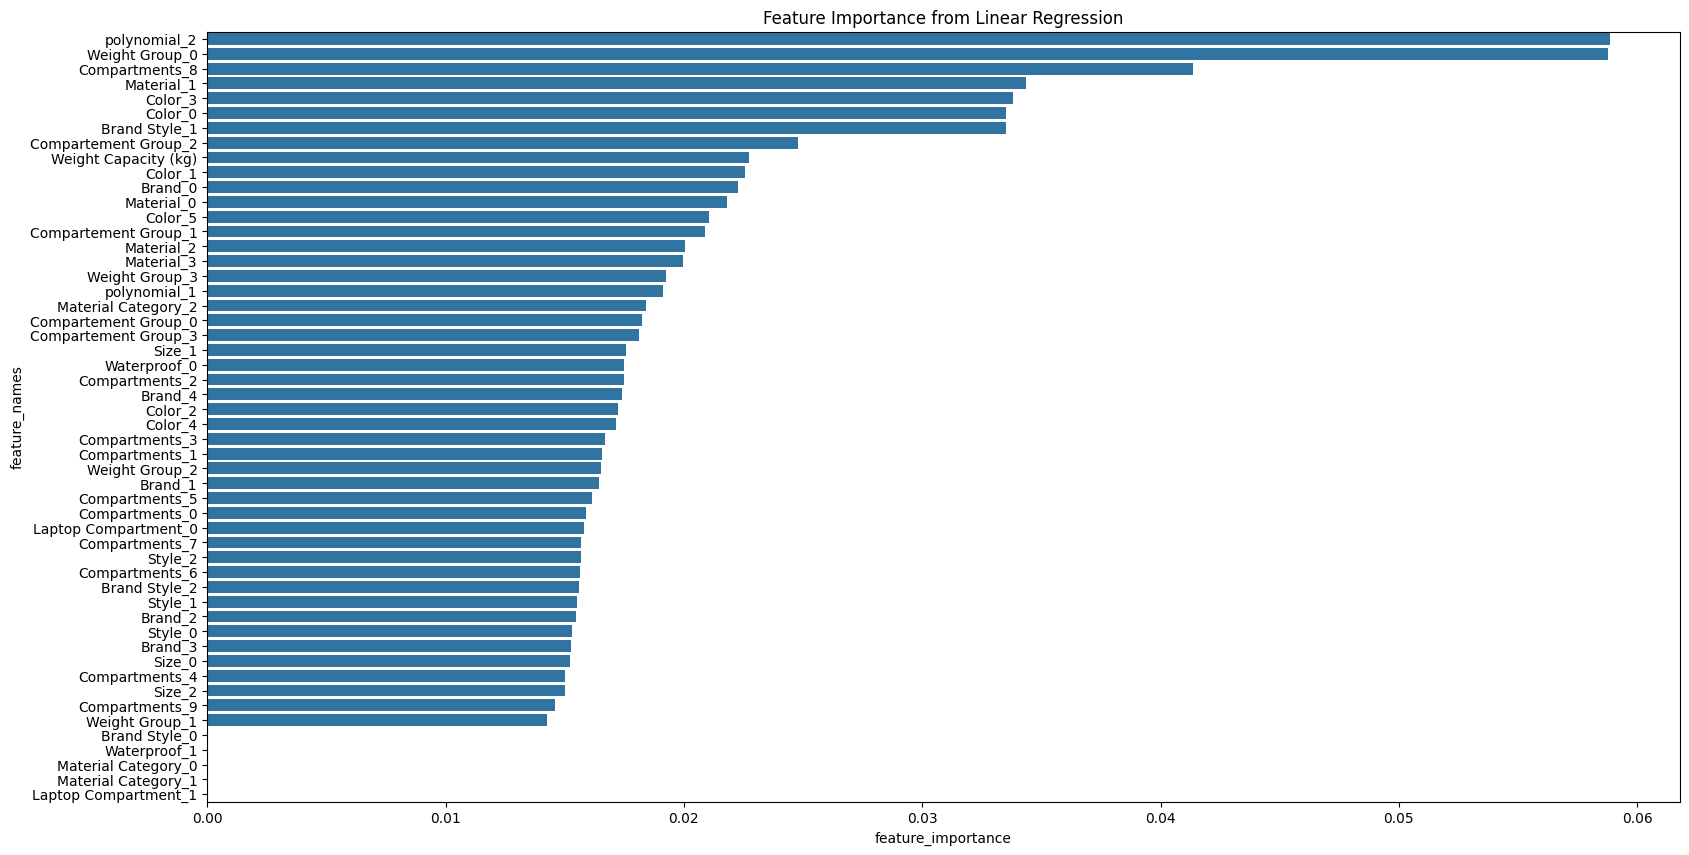

In [17]:
vizualize_feature_importance(
    model=best_model,
    feature_names=column_names,
)

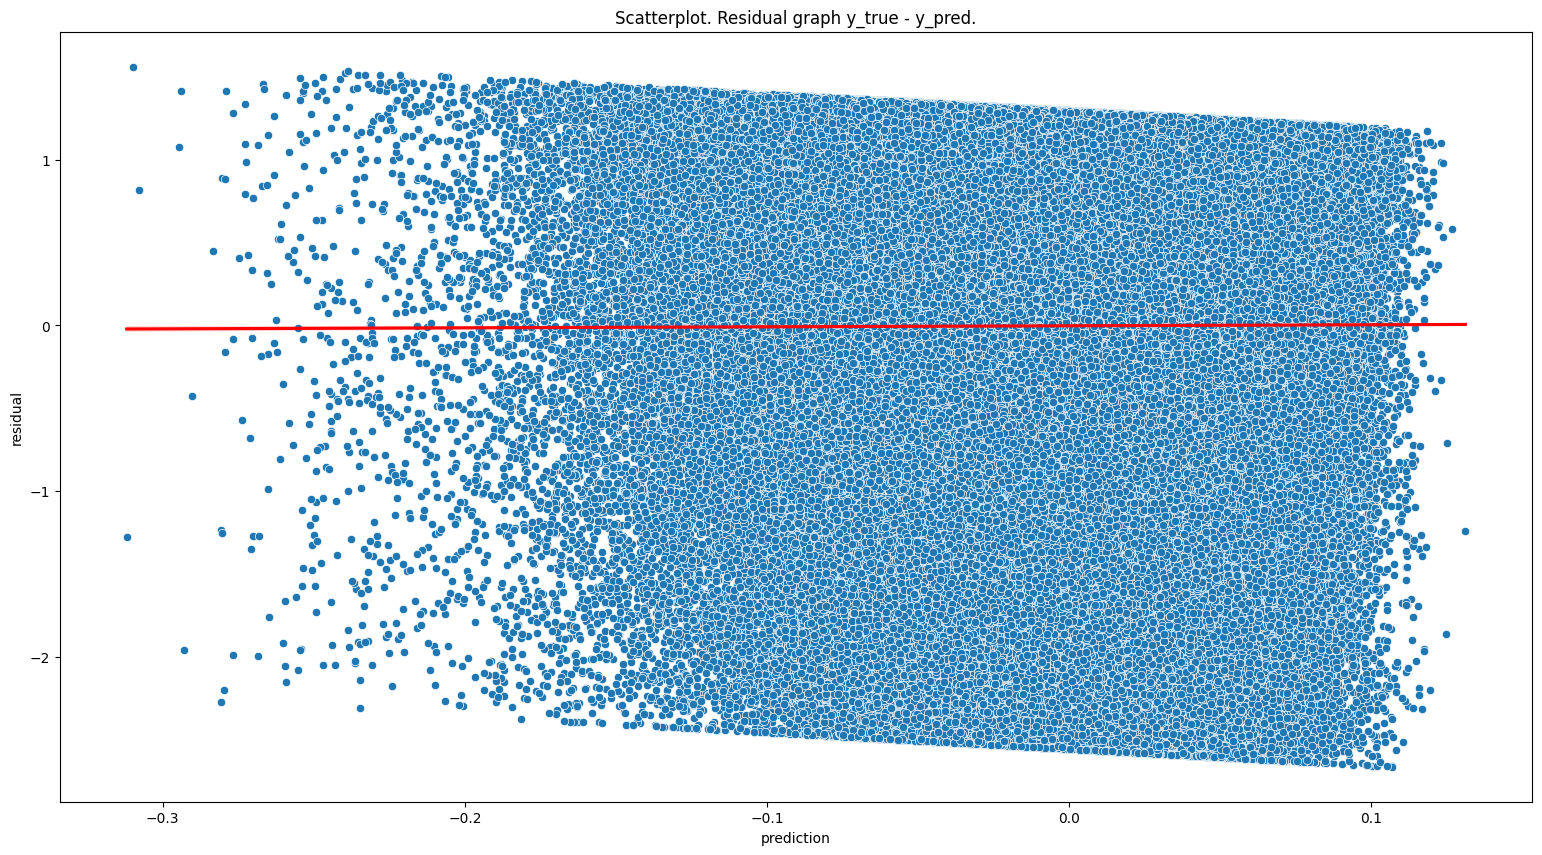

In [22]:
vizualise_residual(
    y_true=y_test["log_Price"].values,
    y_pred=best_model.predict(X_test[column_names]).reshape(-1),
    subset=1_000_000,
)

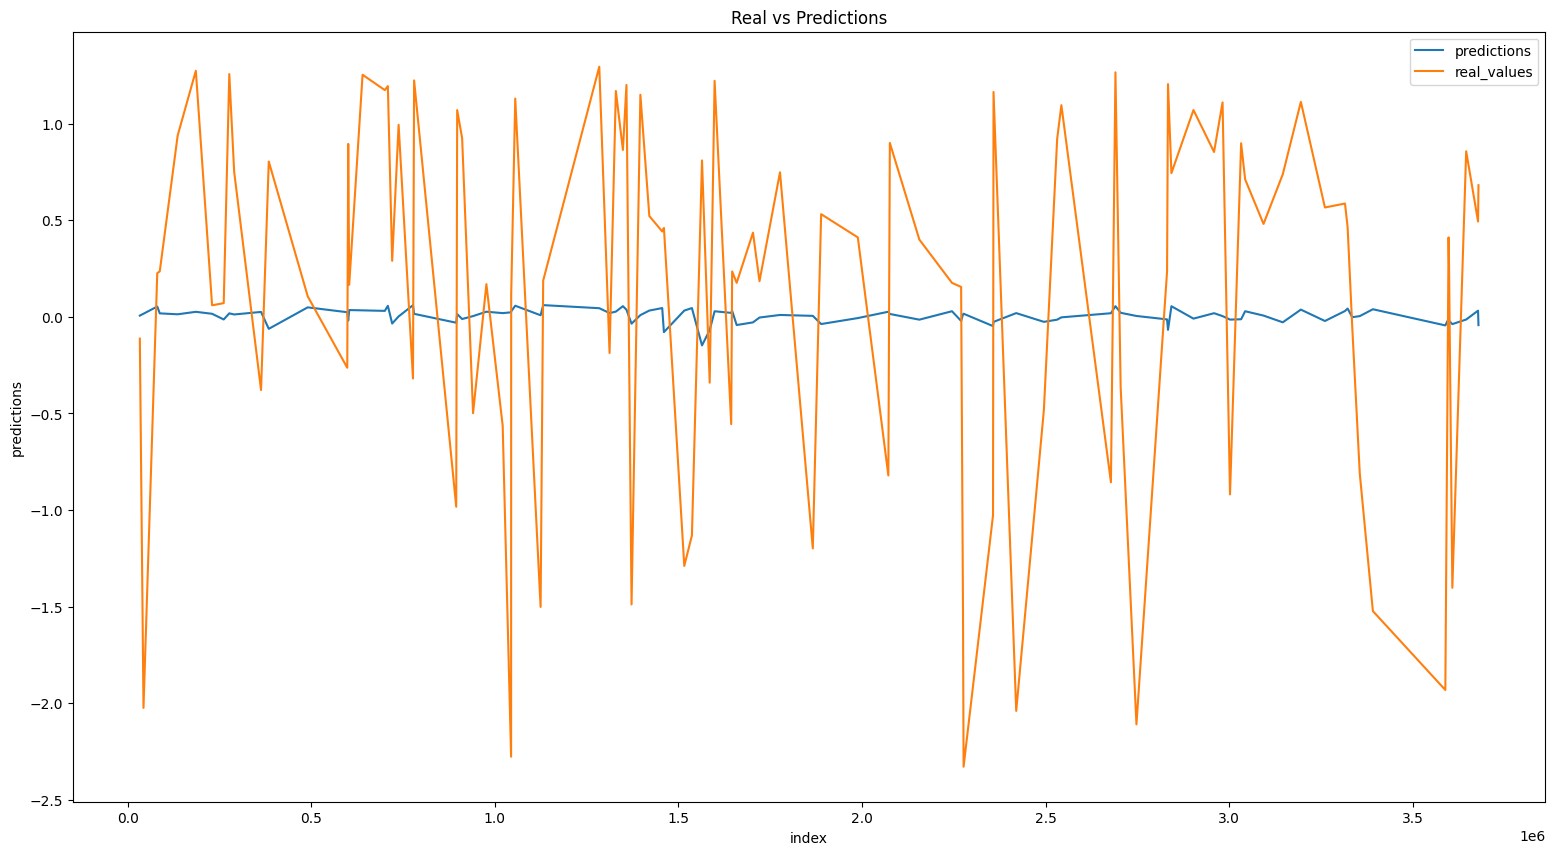

In [23]:
X_test["predictions"] = best_model.predict(X_test[column_names]).reshape(-1)
X_test["real_values"] = y_test.loc[:, ["log_Price"]]

compare_predictions_and_real_values(
    df=X_test.reset_index().iloc[:100]
)

In [24]:
df_test_filled = fill_df_navalues(df=df_test)
df_test_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 200000 non-null  object 
 2   Material              200000 non-null  object 
 3   Size                  200000 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    200000 non-null  object 
 6   Waterproof            200000 non-null  object 
 7   Style                 200000 non-null  object 
 8   Color                 200000 non-null  object 
 9   Weight Capacity (kg)  200000 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


In [25]:
df_test_filled = create_new_features(input_df=df_test_filled)
df_test_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    200000 non-null  int64   
 1   Brand                 200000 non-null  object  
 2   Material              200000 non-null  object  
 3   Size                  200000 non-null  object  
 4   Compartments          200000 non-null  category
 5   Laptop Compartment    200000 non-null  object  
 6   Waterproof            200000 non-null  object  
 7   Style                 200000 non-null  object  
 8   Color                 200000 non-null  object  
 9   Weight Capacity (kg)  200000 non-null  float64 
 10  Weight Group          200000 non-null  object  
 11  Compartement Group    200000 non-null  object  
 12  Brand Style           200000 non-null  object  
 13  Material Category     200000 non-null  object  
dtypes: category(1), float64(1), int64(1)

In [26]:
df_test_filled

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Weight Group,Compartement Group,Brand Style,Material Category
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147,Low Medium,Low,Fancy Street Wear,Expensive
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105,Low,Medium Plus,Street Wear,Medium
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799,Low,High,Fancy Street Wear,Medium
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036,Low Medium,Low,Fancy Street Wear,Medium
4,300004,Adidas,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953,Low,Low,Fancy Street Wear,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,Adidas,Canvas,Large,2.0,Yes,No,Messenger,Red,7.383498,Low,Low,Fancy Street Wear,Medium
199996,499996,Nike,Polyester,Small,9.0,No,Yes,Messenger,Pink,6.058394,Low Low,High,Street Wear,Cheap
199997,499997,Jansport,Nylon,Small,9.0,No,Yes,Tote,Green,26.890163,Medium,High,Casual,Medium
199998,499998,Puma,Nylon,Large,10.0,Yes,No,Tote,Gray,25.769153,Medium,High,Fancy Street Wear,Medium


In [27]:
df_test_polynomial = generate_polynomial_column_using_polynomial_feature_encoder(df=df_test_filled.loc[:, ["id", "Weight Capacity (kg)"]], polynomial_encoder=pf)
df_test_filled = pd.merge(
    df_test_filled,
    df_test_polynomial,
    on="id",
    how="left",
).drop(columns=["Original"])
df_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3692505 entries, 0 to 3692504
Data columns (total 18 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Brand                 object  
 2   Material              object  
 3   Size                  object  
 4   Compartments          category
 5   Laptop Compartment    object  
 6   Waterproof            object  
 7   Style                 object  
 8   Color                 object  
 9   Weight Capacity (kg)  float64 
 10  Price                 float64 
 11  log_Price             float64 
 12  Weight Group          object  
 13  Compartement Group    object  
 14  Brand Style           object  
 15  Material Category     object  
 16  polynomial_1          float64 
 17  polynomial_2          float64 
dtypes: category(1), float64(5), int64(1), object(11)
memory usage: 482.4+ MB


In [28]:
df_test_filled_n = encode_categories_using_encoders_and_scalers(df=df_test_filled, encoders_and_scalers=scalers_and_encoders)
df_test_filled_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    200000 non-null  int64   
 1   Brand                 200000 non-null  category
 2   Material              200000 non-null  category
 3   Size                  200000 non-null  category
 4   Compartments          200000 non-null  category
 5   Laptop Compartment    200000 non-null  category
 6   Waterproof            200000 non-null  category
 7   Style                 200000 non-null  category
 8   Color                 200000 non-null  category
 9   Weight Capacity (kg)  200000 non-null  float64 
 10  Weight Group          200000 non-null  category
 11  Compartement Group    200000 non-null  category
 12  Brand Style           200000 non-null  category
 13  Material Category     200000 non-null  category
 14  polynomial_1          200000 non-nul

In [29]:
df_test_dummy = get_dummies(df=df_test_filled_n)
df_test_dummy

,id,Weight Capacity (kg),polynomial_1,polynomial_2,Brand_0,Brand_1,Brand_2,Brand_3,Brand_4,Material_0,...,Compartement Group_0,Compartement Group_1,Compartement Group_2,Compartement Group_3,Brand Style_0,Brand Style_1,Brand Style_2,Material Category_0,Material Category_1,Material Category_2
0,300000,0.383281,0.216982,0.051866,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,300001,-0.635414,-0.747718,-0.778125,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,300002,-0.886870,-0.924209,-0.889250,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,300003,0.068786,-0.123583,-0.278792,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,300004,-1.159473,-1.087974,-0.977590,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,-1.521318,-1.261047,-1.052260,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
199996,499996,-1.711254,-1.331669,-1.075855,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
199997,499997,1.274691,1.389733,1.441627,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
199998,499998,1.114009,1.155679,1.136228,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [30]:
df_test_dummy["log_scale_Price_prediction"] = best_model.predict(df_test_dummy.loc[:, column_names])
df_test_dummy["log_Price_prediction"] = scalers_and_encoders["Price"].inverse_transform(df_test_dummy.loc[:, ["log_scale_Price_prediction"]])
df_test_dummy = reverse_log(df=df_test_dummy, log_column_name="log_Price_prediction").rename({"reverse_log_Price_prediction": "Price_prediction"})
df_test_dummy

,id,Weight Capacity (kg),polynomial_1,polynomial_2,Brand_0,Brand_1,Brand_2,Brand_3,Brand_4,Material_0,...,Compartement Group_3,Brand Style_0,Brand Style_1,Brand Style_2,Material Category_0,Material Category_1,Material Category_2,log_scale_Price_prediction,log_Price_prediction,reverse_log_Price_prediction
0,300000,0.383281,0.216982,0.051866,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.002944,76.670425,1.984005e+33
1,300001,-0.635414,-0.747718,-0.778125,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.026764,77.743698,5.803087e+33
2,300002,-0.886870,-0.924209,-0.889250,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.023228,77.615944,5.107121e+33
3,300003,0.068786,-0.123583,-0.278792,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.018362,76.113434,1.136696e+33
4,300004,-1.159473,-1.087974,-0.977590,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.098890,73.204193,6.196938e+31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,-1.521318,-1.261047,-1.052260,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.029071,75.726547,7.720076e+32
199996,499996,-1.711254,-1.331669,-1.075855,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.080500,73.868591,1.204264e+32
199997,499997,1.274691,1.389733,1.441627,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.036232,78.085739,8.169691e+33
199998,499998,1.114009,1.155679,1.136228,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.022176,77.577942,4.916682e+33


<Figure size 1900x1000 with 0 Axes>

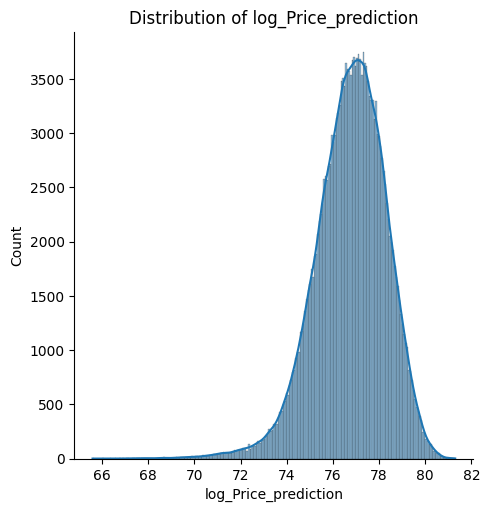

In [32]:
# distplot(df=df_test_filled_n, variable_name="log_Price_prediction")
distplot(df=df_test_dummy, variable_name="log_Price_prediction")

In [34]:
prepare_submission(df_predictions=df_test_dummy.rename(columns={"log_Price_prediction": "prediction"}), )

Generating output: data/my_submission.csv.


In [35]:
submit_file(message="XGBoost optimal, dummy + polynomial features.")
make_a_sound(message="Submission envoyé à Kaggle.")

Submitting data/my_submission.csv to competition:playground-series-s5e2


100%|██████████| 2.48M/2.48M [00:01<00:00, 1.86MB/s]


In [37]:
get_submission_scores()

Retrieving scores from competition:playground-series-s5e2
42991668 - 39.40170 -  - 2025-02-20 09:43:32
42990931 - 39.40668 -  - 2025-02-20 08:49:36
42975840 - 39.39550 -  - 2025-02-19 13:51:46
42973795 - 39.39608 -  - 2025-02-19 11:57:30
42973625 - 39.40033 -  - 2025-02-19 11:42:43
42973519 - 39.40599 -  - 2025-02-19 11:35:46
42973416 - 39.61442 -  - 2025-02-19 11:28:33
42871458 - 39.39965 -  - 2025-02-13 17:05:04
42871175 - 39.40570 -  - 2025-02-13 16:52:15
42871068 - 40.64554 -  - 2025-02-13 16:47:06
42865100 - 39.39980 -  - 2025-02-13 10:12:37
42864363 - 39.41133 -  - 2025-02-13 09:22:25
42850378 - 39.17431 -  - 2025-02-12 13:23:39
42850146 - 40.56604 -  - 2025-02-12 13:06:19
42849704 - 39.20249 -  - 2025-02-12 12:34:08
42849653 - 41.08284 -  - 2025-02-12 12:30:21
42849581 - 41.09588 -  - 2025-02-12 12:24:29
42833411 - 42.52023 -  - 2025-02-11 17:15:43
42832059 - 42.34699 -  - 2025-02-11 16:16:21
42832054 - 41.54405 -  - 2025-02-11 16:16:10
42831717 - 41.54405 -  - 2025-02-11 16:02: